In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, fmin_ncg
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [42]:
data = np.loadtxt('ds-boot-1.csv', delimiter='\t', skiprows=1)

In [293]:
def s_shape_NM(tht, X):
    return 5500-5500*np.e**(-tht*X)*(1+tht*X)

def s_shape(tht, X):
    theta = tht.flatten()
    return theta[0]-theta[0]*np.e**(-theta[1]*X)*(1+theta[1]*X)
    #return 5500-5500*np.e**(-theta[1]*X)*(1+theta[1]*X)
    
def costJ_NM(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape_NM(theta, X)
    cost = ((predicted-y)**2).sum()/2/m
    return cost
    
def costJ(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape(theta, X)
    cost = ((predicted-y)**2).sum()/2/m
    return cost

def log_costJ(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape(theta, X)
    cost = np.mean((np.log(1+y) - np.log(1+predicted))**2)
    return cost

def gradJ(theta, X, y):
    theta_loc = theta.flatten()
    grad = np.empty(theta.size)
    a = theta_loc[0]
    b = theta_loc[1]
    grad[0] = ((1-np.e**(-b*X)*(1+b*X))*(s_shape(theta,X)-y)).sum()/m
    grad[1] = (a*X**2*b*np.e**(-b*X)*(s_shape(theta,X)-y)).sum()/m
    return grad

def log_gradJ(theta, X, y):
    theta_loc = theta.flatten()
    grad = np.empty(theta.size)
    a = theta_loc[0]
    term1 = np.log(1+y)-np.log(1+s_shape(theta_loc,X))
    term2 = -s_shape(theta_loc,X)/a/(1+s_shape(theta_loc,X))
    grad[0] = 2*np.mean(term1*term2)
    b = theta_loc[1]
    term3 = -1/(1+s_shape(theta_loc,X))
    term4 = a*b*X**2*np.e**(-b*X)
    grad[1] = 2*np.mean(term1*term3*term4)
#     print(term1)
#     print(term2)
#     print(term3)
#     print(term4)
    return grad

def grad_descent(cost_func, grad_func, x, y, theta_init, alpha1, alpha2, epsilon, max_iters=1500):
    n = theta_init.size
    theta = theta_init.copy()
    p_cost = cost_func(theta, x,y) + epsilon
#     print(p_cost)
    for i in range(max_iters):
        c_cost = cost_func(theta,x,y)
        if c_cost > p_cost - epsilon:
#             print('Convergence @ theta = {}'.format(theta))
#             print('Cost function value = {}'.format(c_cost))
#             print('Number of iterations: {}'.format(i))
            return theta
        grad = grad_func(theta,x,y)
        theta[0] = theta[0] - alpha1*grad[0]
        theta[1] = theta[1] - alpha2*grad[1]
        
#     print('Failed to converge')
#     print('Current theta = {}'.format(theta))
#     print('Cost function value = {}'.format(c_cost))
    return theta  

In [43]:
X = data[:,0]
y = data[:,2]
y_pred = s_shape(theta_init, X)

In [57]:
log_costJ(theta_init, X, y)

57.084337882972399

In [55]:
mean_squared_log_error(y, y_pred)

57.084337882972399

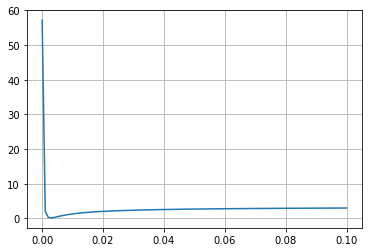

In [58]:
x = np.linspace(0,.1,100).reshape(100,1)
gr = np.insert(x,0,5000,axis=1)
grad = [log_costJ(x, data[:,0], data[:,2]) for x in gr]
plt.plot(x,grad)
plt.grid()
plt.show()

In [225]:
theta_init = np.array([60, .01])
m = data.shape[0]

In [166]:
result = fmin_cg(log_costJ, theta_init, fprime=log_gradJ, args=(data[:,0], data[:,2]), gtol=1e-100)
print(result)

         Current function value: 2.729987
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 55
[  5.38803356e+02   1.33570457e-02]


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in power
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.6/site-packages/i

In [226]:
result = minimize(costJ_NM, 0.1, method='Nelder-Mead', args=(data[:,0], data[:,2]))
result = result.x
result = np.array([5500,result])
print(result)

[  5.50000000e+03   2.99032211e-03]


In [228]:
result = grad_descent(log_costJ, log_gradJ, X, y, theta_init, 50000, 1e-5, epsilon=1e-20, max_iters=50000)

13.7045034823
Failed to converge
Current theta = [[  4.63288312e+03]
 [  2.37948830e-03]]
Cost function value = 0.13182234818129002


In [229]:
result = grad_descent(log_costJ, log_gradJ, X, y, result, 500000, 1e-8, epsilon=1e-20, max_iters=5000)

0.165748520754
Failed to converge
Current theta = [[  7.58051120e+03]
 [  2.01586609e-03]]
Cost function value = 0.07464449362407696


In [115]:
log_costJ(theta_init,X,y)

1.4162313288740929

In [113]:
grads = log_gradJ(np.array([5500,.01]), data[:,0], data[:,2] )

In [164]:
grads = log_gradJ(result, data[:,0], data[:,2] )

In [197]:
grads = log_gradJ(theta_init, data[:,0], data[:,2] )

In [198]:
grads

array([-0.1084393 ,  0.01464653])

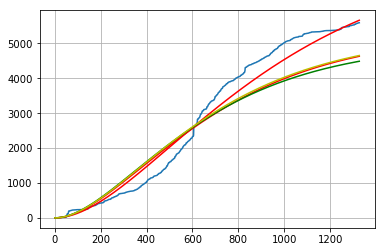

In [292]:
fig = plt.figure()

ax = plt.axes()
ax.grid()
ax.plot(data[:,0], data[:,2])
ax.plot(data[:,0], s_shape(result, data[:,0]), 'r')
ax.plot(data[:,0], s_shape(coefs[0], data[:,0]), 'r')
ax.plot(data[:,0], s_shape(coefs[1], data[:,0]), 'g')
ax.plot(data[:,0], s_shape(coefs[2], data[:,0]), 'y')

plt.show()

Part 2

In [231]:
def create_B_sample_indices(dataset, B):
    m = dataset.shape[0]
    n = dataset.shape[1]
    result_indices = np.random.choice(m, (B,m))
    return result_indices

In [294]:
def train_B_regressions(dataset, B):
    indices_2d = create_B_sample_indices(dataset,B)
    m = dataset.shape[0]
    n = 2
    X = dataset[:,0]
    y = dataset[:,2]
    theta_init = np.array([60, .01])
    result = np.empty((B,n))
#     sigmas  = np.empty(B)
    i=0
    for line in indices_2d:
#         print(line)
#         print(dataset[line][:,1:-5].shape)
#         coefs = regr.coef_
#         print(coefs.shape)
#         result[i] = np.insert(coefs,0, regr.intercept_, axis=1)
        coefs = grad_descent(log_costJ, log_gradJ, X[line], y[line], theta_init, 50000, 1e-5, epsilon=1e-20, max_iters=50000)
        result[i] = grad_descent(log_costJ, log_gradJ, X[line], y[line], coefs, 500000, 1e-8, epsilon=1e-20, max_iters=5000)
#         sigmas[i] = np.std(regr.predict(dataset[line][:,1:-5])[:,1]-dataset[line][:,-4])
#         result = np.append(result, coefs)
        i += 1
#     return result, sigmas
    return result

In [295]:
def analyze_coefs(coefs):
#     for value in range(coefs.shape[1]):
#         print('Target {}:'.format(value))
    for feature_num in range(coefs.shape[1]):
        print('\tFeature {:d}:\n\t\t95%-Confidence interval: {:.3e} +/- {:.3e}\n\t\tRange: {:.3e} - {:.3e}\n\t\t% of outliers: {:.2f}'.format(
            feature_num+1, 
            coefs[:,feature_num].mean(),
            coefs[:,feature_num].std(),
            coefs[:,feature_num].min(), 
            coefs[:,feature_num].max(), 
            coefs[:,feature_num][(coefs[:,feature_num]>coefs[:,feature_num].mean()+3*coefs[:,feature_num].std()) | (coefs[:,feature_num]<coefs[:,feature_num].mean()-3*coefs[:,feature_num].std())].size  /B                ))

In [296]:
B=1000

In [ ]:
coefs = train_B_regressions(data, B)

In [ ]:
analyze_coefs(coefs)

In [283]:
coefs

array([[  5.30169030e+03,   2.70519934e-03],
       [  5.01134866e+03,   2.88648673e-03],
       [  5.28210335e+03,   2.76165898e-03],
       [  6.26006796e+03,   2.35508901e-03],
       [  5.96529336e+03,   2.44646206e-03],
       [  6.29439422e+03,   2.32990965e-03],
       [  4.81844091e+03,   3.05464180e-03],
       [  5.52839179e+03,   2.66020934e-03],
       [  5.32650371e+03,   2.77450794e-03],
       [  5.61806471e+03,   2.60139649e-03]])

In [ ]:
1+5


In [ ]:
np.savetxt('coefs_task2.txt', coefs, delimiter=',')